# Week 4 - Picking Loans using Regression of Loan Returns

This notebook carries out the following steps
  1. Reads the saved returns data from the pickle 
  2. Build several classifier and regression models with the data (Save the time-consuming models for loading in later re-runs)
  3. Uses the regressions for returns and the classification models from before for implementimg some simple strategies for picking loans to invest in. A new greedy strategy has been added but you should try others.
  4. Tests these strategies on a portfolio of 100 loans
  5. Performs a sensitivity analysis of the performance of the loan to the number of loans invested in from 100 to 1000
  6. (optional) Re-run the test strategies on different test and train sets from different time periods
  
Things for you to do
- Decide on one of the return columns to focus on and justify why. Note that you should do this BEFORE looking at the results of the regressions for predicting all the return columns to not get biased
- For the return column you picked, examine the various types of regularized regressions to pick the best regularized model, or simply use automated analysis to pick a subset of variables to include in a regular regression. You will need to finalize your best model before moving to the next step
- For the return column you picked, try various strategies for picking the best set of loans to invest in, using the ideas from the case. You should use the best model for the return column you picked here
- Interpret the results of the different strategies
- Vary the number of loans selected and see how it affects the results
- Think of a new rule to pick the best loans using the analyses you have done so far, and add it to the script. e.g. 
    - Rank by return but only accept if P(default) is not too high. 
    - If you want to go further, you can try to implement a two-stage model: First, estimate expected return in two stages: Stage 1 - default or not default, Stage 2 - resulting return given stage 1 state, and combine them using Pr(default) predicted from another classification model from last week
    
Prepare your presentation. Your presentation should contain about 5 to 6 slides. Add an extra slide at the end if you tried the BONUS.
1. Begin by stating the objective of the presentation and what your objective is. Which questions do you seek to answer? What are the main points of the presentation?
2. (3) Which method did you use to compute returns? Why? How did the different predictive model perform? Which metric are you using to evaluate the predictions? 
4.  Compare the different strategies to select loans based on the predictions obtained. Present a table containing the predicted return percentages. Which method do you think Alice should use? Which new strategy do you propose to select the loans? Does it perform better than the previous ones?
5. Include your robustness results. How do your strategies scale? Do your results change by changing the number of loans you are able to invest in? what if you have a limited budget? Does this affect the best strategy that you selected on the previous slide?
6.  State your conclusions. What is the main idea you wish to convey with the presentation? Do you think the findings from this script will be useful to solve the overall problem? What are the main takeways from the analysis you performed?

BONUS
- Is there correlation between higher predicted returns and probability of default (computed in module M3). If so, how can you exploit this to improve your models?
- Can you improve your models using the results from module 2? If so, clearly state the improvements in terms of the metric you used to evaluate your models.
- Can you derive new variables from the original ones to improve your models? If so, clearly state the improvements in terms of the metric you used to evaluate your models.
- Use a more sophisticated (although less interpretable) predictive model such as tree boosting or support vector machine to obtain new results. Do these models perform better?
- Are there any exogenous variables (i.e. variables from other data sets, such as economic growth of the country) you might use to improve your models?

In [1]:
# Load general utilities
# ----------------------
import pandas as pd
import pickle 
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import time
import seaborn as sns

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
## from gurobipy import *
# from sklearn.externals.six import StringIO  
from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
#from scipy.interpolate import spline

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
##  read saved models
infile = open('./week4_saved_models','rb')
saved_models = pickle.load(infile)
models_to_save = saved_models.copy() # save new models in this new dict
infile.close()
print('models loaded:\n', saved_models.keys())

models loaded:
 dict_keys(['rf1213', 'reg_rf1213', 'reg_rf_separate1213', 'reg_mlp1213', 'l1_logistic1213'])


In [3]:
# You can also import a dill pickle with the whole session from before
# pip install ipython
# import dill
# dill.load_session('week4.pkl')

In [4]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

## Define a default random seed and an output file

In [5]:
default_seed = 1
output_file = "output_sample"

In [6]:
# Create a function to print a line to our output file
def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data (2012-13) and engineer the features

In [1]:
# Read the data and features from the pickle
data1213, discrete_features, continuous_features, ret_cols = pickle.load( open( "./PickleData/ret_data.pickle", "rb" ) )

data = data1213.copy()

# Create the outcome
data["outcome"] = data.loan_status.isin(["Charged Off", "Default"])

# Create a feature for the length of a person's credit history at the
# time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')


# Randomly assign each row to a training and test set. We do this now
# because we will be fitting a variety of models on various time periods,
# and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
data['train'] = np.random.choice([True, False], size = len(data), p = [0.7, 0.3])

# Create a matrix of features and outcomes, with dummies. Record the
# names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

NameError: name 'pickle' is not defined

In [8]:
X.shape

(240407, 54)

## Prepare functions to fit and evaluate models

In [9]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 20000,
                    n_samples_test = 10000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that rowFdecisipn
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
    
    # Filter down the data to the required date range, and downsample
    # as required
#     print("sizes:", train.shape[0], data.shape[0], data_subset.shape[0])
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum() 
                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum() 
                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [10]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

In [11]:
## Set up for grid search for cross validation 
cv_parameters = {"alpha":np.logspace(-4, 4, num = 10)}

GridSearchCV("Ridge Classifier", cv_parameters)

GridSearchCV(estimator='Ridge Classifier',
             param_grid={'alpha': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])})

## Feature preparation

In [12]:
# final_features = [i for i in discrete_features + continuous_features if i not in ["grade", "int_rate", "installment"]]
final_features = [i for i in discrete_features + continuous_features]
all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in final_features]

## useful when choosing the most significant features
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

In [13]:
## Process data here:
data_dict1213 = prepare_data(data_subset = np.array([True]*len(data)), feature_subset = final_features)

### Ridge Classifier

In [14]:
cv_parameters = {"alpha":np.logspace(-4, 4, num = 10)}
# cv_parameters = {"alpha":[0.0001]}
ridge_clf1213 = fit_classification(RidgeClassifier(), data_dict1213, 
                             cv_parameters = cv_parameters, model_name = "Ridge Classifier")

  Model: Ridge Classifier
Fit time: 0.45 seconds
Optimal parameters:
{'alpha': 0.0001}

Accuracy:  0.8061
              precision    recall  f1-score   support

  No default     0.8070    0.9976    0.8923      8049
     Default     0.6200    0.0159    0.0310      1951

    accuracy                         0.8061     10000
   macro avg     0.7135    0.5068    0.4616     10000
weighted avg     0.7705    0.8061    0.7242     10000


Similarity to LC grade ranking:  0.7070644727515558


### Naive Bayes

  Model: Gaussian Naive Bayes
Fit time: 0.08 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.8049
              precision    recall  f1-score   support

  No default     0.8049    1.0000    0.8919      8049
     Default     0.0000    0.0000    0.0000      1951

    accuracy                         0.8049     10000
   macro avg     0.4024    0.5000    0.4460     10000
weighted avg     0.6479    0.8049    0.7179     10000



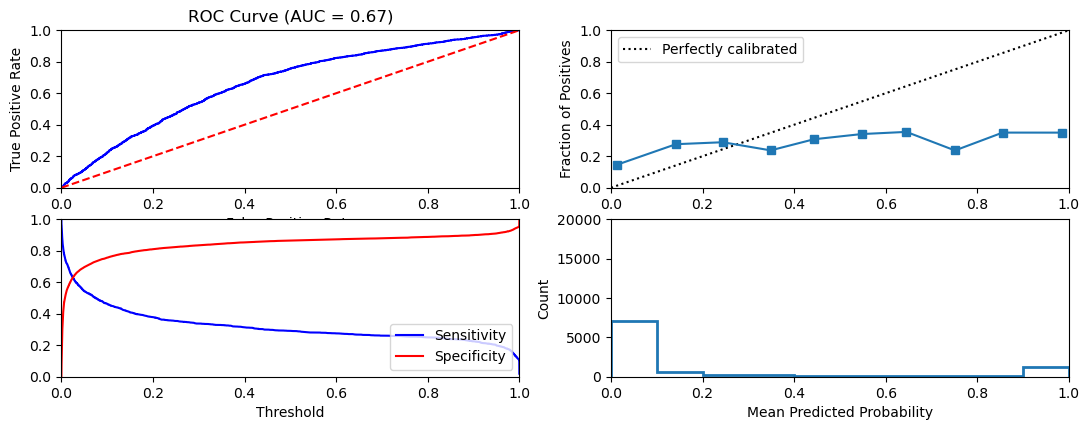


Similarity to LC grade ranking:  0.5941996107632512
Brier score: 0.2213189329962965
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.6512]


In [15]:
gnb1213 = fit_classification(GaussianNB(), data_dict1213,
                model_name = "Gaussian Naive Bayes")

### $l_1$ penalized logistic regression

In [16]:
# Read models saved in a dictionary
l1_logistic1213 = saved_models['l1_logistic1213']

# Run the following the first time through
# l1_logistic = LogisticRegression(penalty = 'l1',solver='liblinear')
# cv_parameters = {"C":np.logspace(0, 6, num = 10)}
# l1_logistic1213 = fit_classification(l1_logistic, data_dict1213,
#                       cv_parameters = cv_parameters, model_name = "l1 Penalized Logistic Regression")

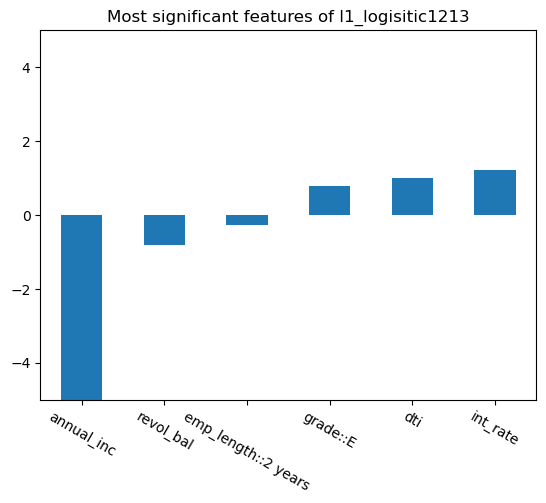

In [17]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l1_logistic1213['model'].coef_)[0,:3]) + list(np.argsort(l1_logistic1213['model'].coef_)[0,-3:])
bplot = pd.Series(l1_logistic1213['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,5))
p1.set_xticklabels(xticks)
plt.title('Most significant features of l1_logisitic1213')
plt.show()

### $l_2$ penalized logistic regression

  Model: l2 Penalized Logistic Regression
Fit time: 2.86 seconds
Optimal parameters:
{'C': 0.046415888336127774}

Accuracy-maximizing threshold was: 0.4535953539199691
Accuracy:  0.805
              precision    recall  f1-score   support

  No default     0.8129    0.9843    0.8904      8049
     Default     0.5020    0.0651    0.1152      1951

    accuracy                         0.8050     10000
   macro avg     0.6574    0.5247    0.5028     10000
weighted avg     0.7522    0.8050    0.7392     10000



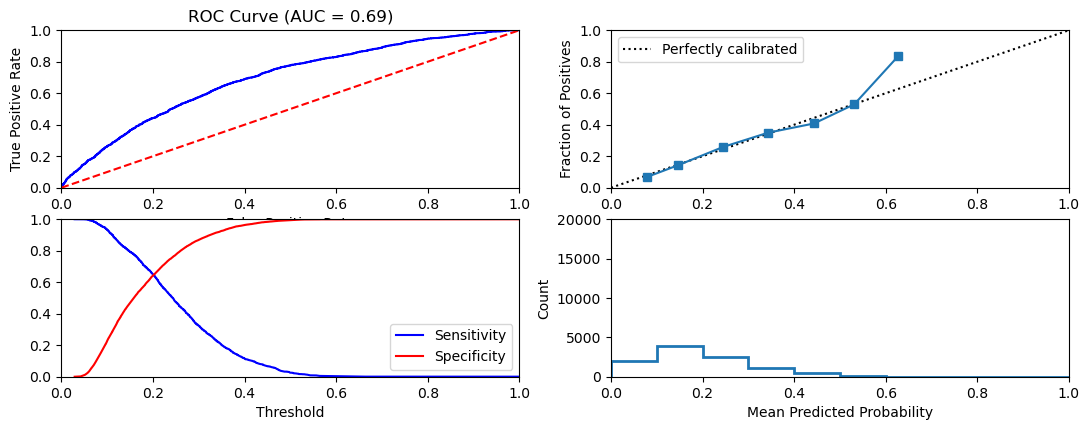


Similarity to LC grade ranking:  0.7342431591157894
Brier score: 0.14539645599755485
Were parameters on edge? : False
Score variations around CV search grid : 0.22977085015216162
[0.8033  0.8033  0.8033  0.80515 0.80495 0.8047  0.8045  0.8045  0.8044
 0.80435]


In [18]:
l2_logistic = LogisticRegression(penalty = 'l2')
cv_parameters = {"C":np.logspace(-4, 4, num = 10)}

l2_logistic1213 = fit_classification(l2_logistic, data_dict1213,
                        cv_parameters = cv_parameters, model_name = "l2 Penalized Logistic Regression")

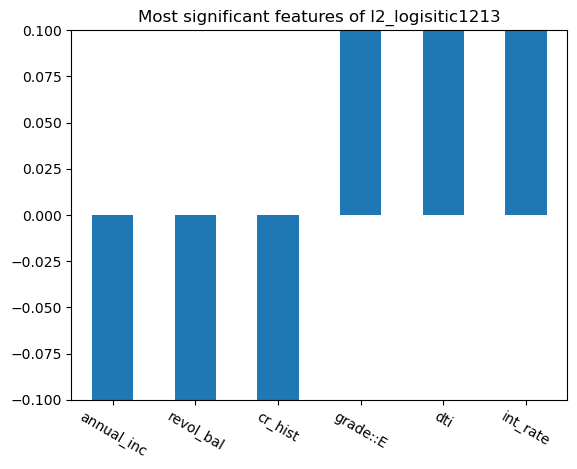

In [19]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic1213['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic1213['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic1213['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-0.1,0.1))
p1.set_xticklabels(xticks)
plt.title('Most significant features of l2_logisitic1213')
plt.show()

In [20]:
coef_table = pd.DataFrame({"feature": selected_features[top_and_bottom_idx], "coeff": l2_logistic1213['model'].coef_[0,top_and_bottom_idx]})
print(coef_table)

       feature     coeff
3   annual_inc -0.657347
5    revol_bal -0.285030
11     cr_hist -0.184760
26    grade::E  0.610241
4          dti  1.026901
9     int_rate  1.202641


### Decision tree

  Model: Decision tree
Fit time: 1.91 seconds
Optimal parameters:
{'min_samples_leaf': 700}

Accuracy-maximizing threshold was: 1
Accuracy:  0.8049
              precision    recall  f1-score   support

  No default     0.8049    1.0000    0.8919      8049
     Default     0.0000    0.0000    0.0000      1951

    accuracy                         0.8049     10000
   macro avg     0.4024    0.5000    0.4460     10000
weighted avg     0.6479    0.8049    0.7179     10000



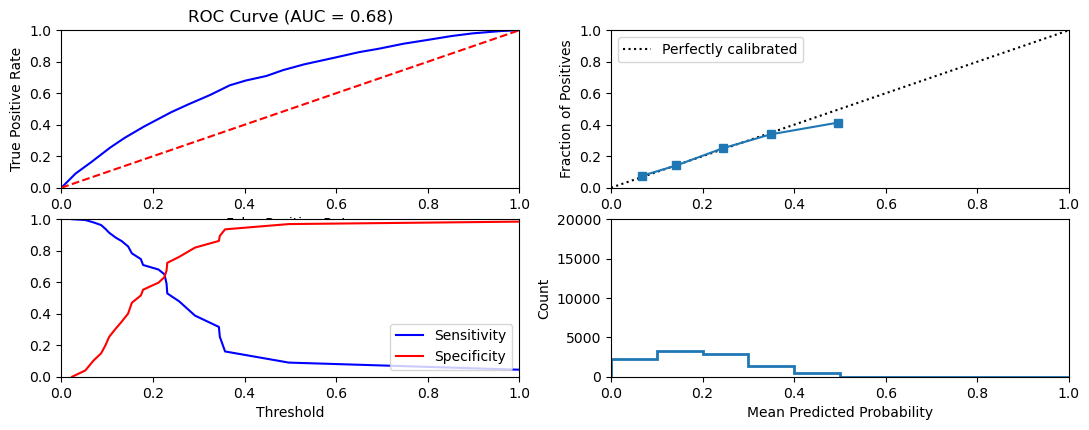


Similarity to LC grade ranking:  0.6834410609931707
Brier score: 0.14728942749173282
Were parameters on edge? : False
Score variations around CV search grid : 0.3485621810033642
[0.8005  0.80125 0.8033  0.8033  0.8033  0.8033  0.8033  0.8033  0.8033 ]


In [21]:
decision_tree = DecisionTreeClassifier()
cv_parameters = {'min_samples_leaf':[500,600,700,800,900,1000, 1100, 1200, 1300]}

dt1213 = fit_classification(decision_tree, data_dict1213, 
                          cv_parameters = cv_parameters, model_name = "Decision tree")

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/ravi/opt/anaconda3

  added / updated specs:
    - pydot
    - python-graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pydot-1.4.1                |   py39hecd8cb5_0          42 KB
    python-graphviz-0.20.1     |   py39hecd8cb5_0          64 KB
    ------------------------------------------------------------
                                           Total:         106 KB

The following NEW packages will be INSTALLED:

  pydot      

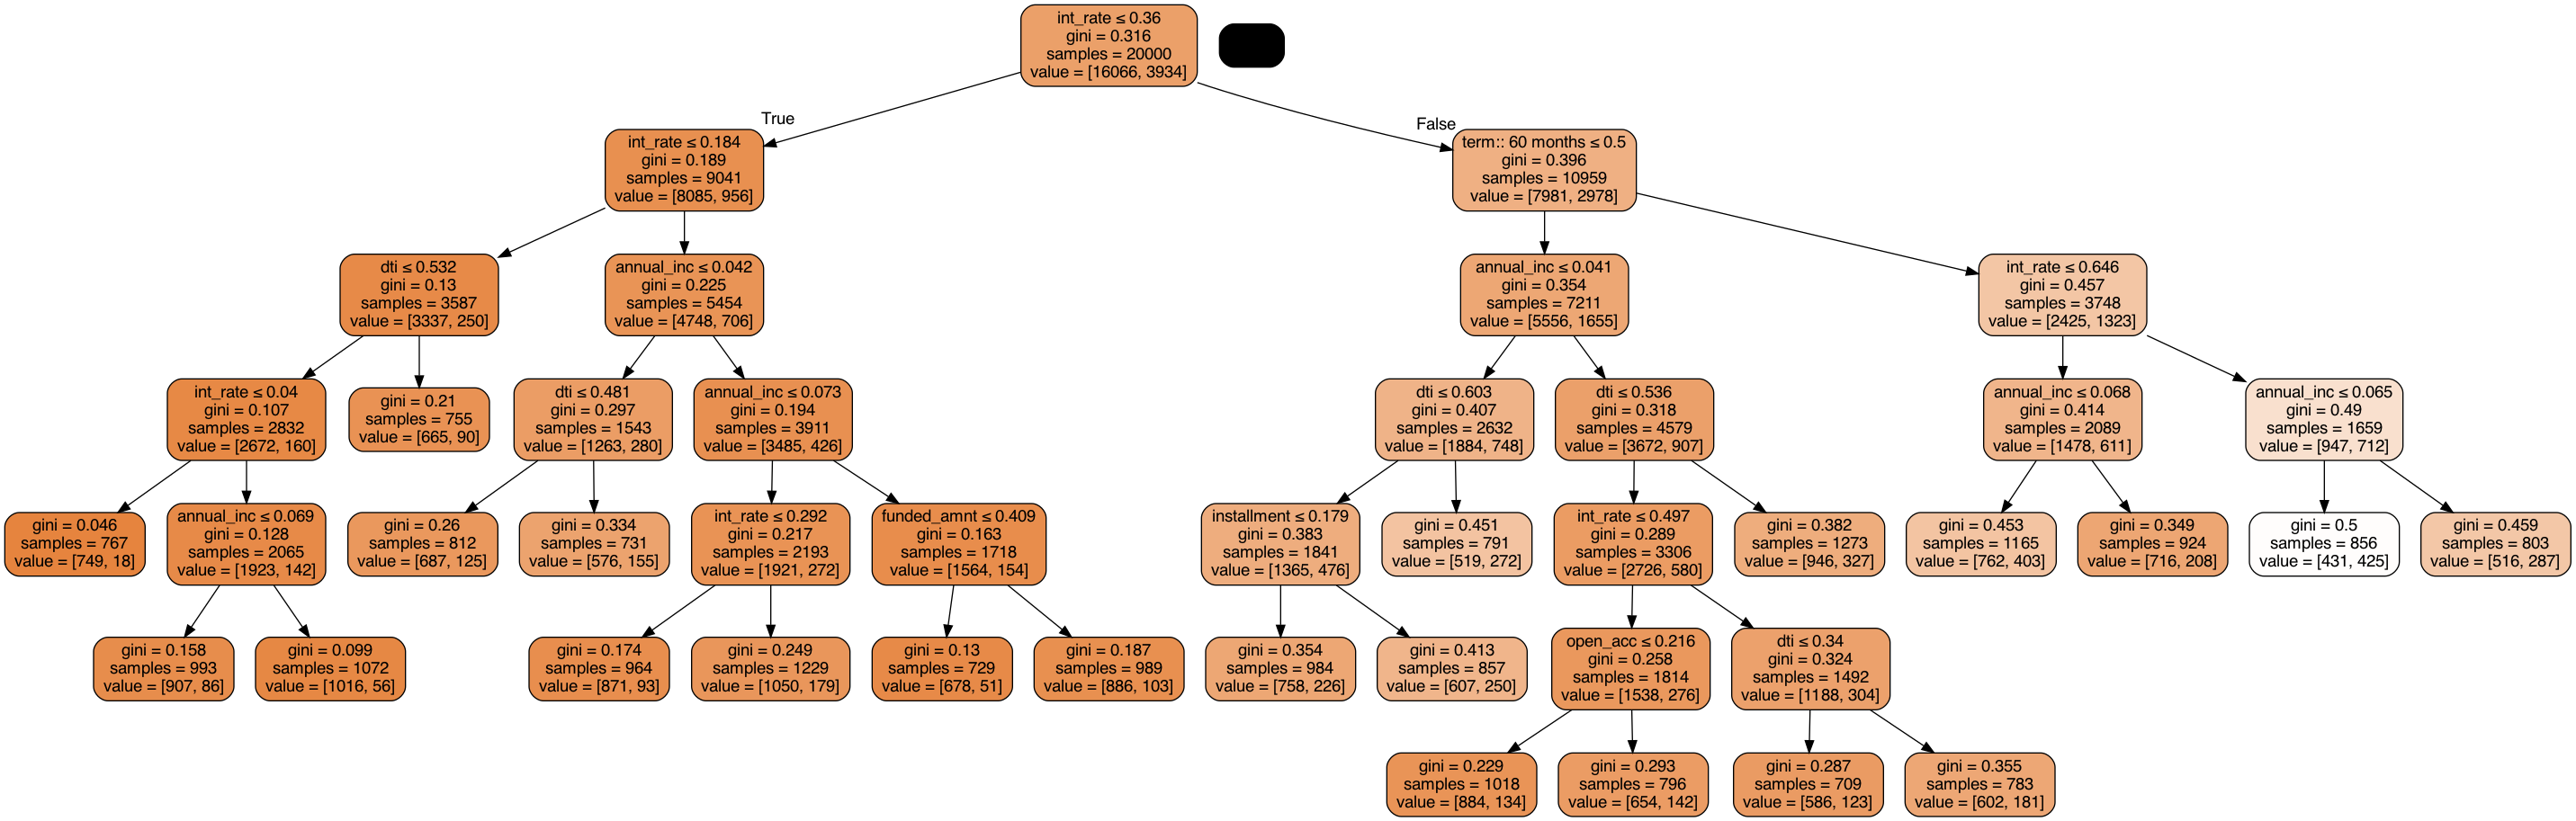

In [23]:
# Visualize the decision tree
# Zooming-in is allowed by double click
# from sklearn.externals.six import StringIO 
from six import StringIO
#!conda install -c conda-forge pygraphviz -y
!conda install python-graphviz pydot -y
import graphviz

dot_data = StringIO()
export_graphviz(dt1213['model'], out_file=dot_data,  
                feature_names=selected_features,filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### ($\star$) Random forest
Takes nearly 10 minutes given the large data set! You may read the saved output by running:

In [24]:
# Read models saved from a dictionary
rf1213 = saved_models['rf1213']

In [25]:
#rf1213 = RandomForestClassifier()
#cv_parameters = {'min_samples_leaf':[1, 2, 3, 5, 8, 13, 17, 20, 40], 'n_estimators': [35, 60, 80, 100, 150] }

#rf1213 = fit_classification(rf1213, data_dict1213,
#                                   cv_parameters=cv_parameters, model_name="Random forest")

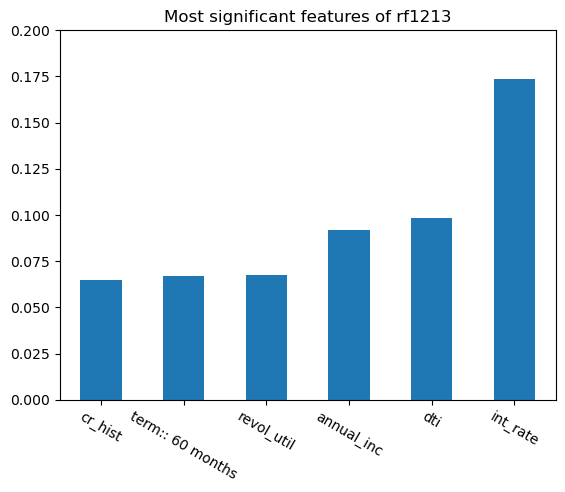

In [26]:
## Plot top 6 most significant features
top_idx = list(np.argsort(rf1213['model'].feature_importances_)[-6:]) 
bplot = pd.Series(rf1213['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.title('Most significant features of rf1213')
plt.show()

# Build and Test Regression Models for returns

In [27]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False,
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen

    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''

    np.random.seed(random_state)

    # --------------------------
    #   Step 1 - Load the data
    # --------------------------

    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']

    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}

    for ret_col in col_list:

        #y_train = data.loc[filter_train, ret_col].as_matrix()
        #y_test = data.loc[filter_test, ret_col].as_matrix()
        y_train = data.loc[filter_train, ret_col].to_numpy()
        y_test = data.loc[filter_test, ret_col].to_numpy()

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_

            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)

            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_

            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

## Run regression models on 2012-13 data

In [28]:
final_data, discrete_features, continuous_features, ret_cols = pickle.load( open( "./PickleData/ret_data.pickle", "rb" ) )

In [29]:
data = data1213.copy()

### Lasso-Lars regressor

In [30]:
# First, trying LASSO penalized regression with a variety of parameters,
# it becomes clear a simple regression is best

cv_parameters = {'alpha': np.logspace(-8, -1, num = 8) }

reg_lasso1213 = fit_regression(linear_model.LassoLars(), data_dict1213,  
               cv_parameters = cv_parameters, separate = False, model_name = "Lasso")

  Model: Lasso  Return column: ret_PESS
Fit time: 0.42 seconds
Optimal parameters:
{'alpha': 1e-07}

Testing r2 score: 0.034047683913573046
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -123.96672540879389
All test scores : [-0.03190206 -0.03186514 -0.03410088 -0.0396516  -0.0713673  -0.0713673
 -0.0713673  -0.0713673 ]
  Model: Lasso  Return column: ret_OPT
Fit time: 0.36 seconds
Optimal parameters:
{'alpha': 1e-06}

Testing r2 score: 0.022802815833203094
Were parameters on edge (model) : False
Score variations around CV search grid (model) : 120.54155494909456
All test scores : [ 0.01606416  0.01615163  0.0167807   0.01665704 -0.00344702 -0.00344702
 -0.00344702 -0.00344702]
  Model: Lasso  Return column: ret_INTa
Fit time: 0.35 seconds
Optimal parameters:
{'alpha': 1e-08}

Testing r2 score: 0.033660769916663
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -161.65185309155154
All test scores : [-0.0234

### Ridge regressor

In [31]:
cv_parameters = {'alpha': np.logspace(-8, -1, num = 8) }

reg_ridge1213 = fit_regression(linear_model.Ridge(), data_dict1213,
               cv_parameters = cv_parameters, separate = False, model_name = "Ridge")

  Model: Ridge  Return column: ret_PESS
Fit time: 0.21 seconds
Optimal parameters:
{'alpha': 0.1}

Testing r2 score: 0.03364379840984688
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -0.06507979245562741
All test scores : [-0.03207792 -0.03207792 -0.03207792 -0.03207792 -0.0320779  -0.0320777
 -0.03207576 -0.03205706]
  Model: Ridge  Return column: ret_OPT
Fit time: 0.18 seconds
Optimal parameters:
{'alpha': 0.1}

Testing r2 score: 0.022248069877659815
Were parameters on edge (model) : True
Score variations around CV search grid (model) : 1.0134939338844173
All test scores : [0.01579067 0.01579067 0.01579068 0.0157907  0.01579092 0.01579308
 0.0158136  0.01595235]
  Model: Ridge  Return column: ret_INTa
Fit time: 0.18 seconds
Optimal parameters:
{'alpha': 0.1}

Testing r2 score: 0.03321782348332558
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -0.0981812497947266
All test scores : [-0.02333102 -0.023331

### Ordinary least squares

In [32]:
reg_linear1213 = fit_regression(linear_model.LinearRegression(), data_dict1213,
               separate = False, model_name = "Linear Regression")

  Model: Linear Regression  Return column: ret_PESS
Fit time: 0.1 seconds
Optimal parameters:
{}

Testing r2 score: 0.0335603304193538
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -0.0
All test scores : [-1.57499841e+19]
  Model: Linear Regression  Return column: ret_OPT
Fit time: 0.06 seconds
Optimal parameters:
{}

Testing r2 score: 0.02221319300479052
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -0.0
All test scores : [-8.89453603e+18]
  Model: Linear Regression  Return column: ret_INTa
Fit time: 0.06 seconds
Optimal parameters:
{}

Testing r2 score: 0.03311148067220393
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -0.0
All test scores : [-8.90305937e+18]
  Model: Linear Regression  Return column: ret_INTb
Fit time: 0.06 seconds
Optimal parameters:
{}

Testing r2 score: 0.031882770705712216
Were parameters on edge (model) : False
Score variations around 

### ($\star$) Multi-layer perceptron regressor

In [33]:
# The next cell takes a long time to run.
# you may skip the computation by running if you saved the model already
reg_mlp1213 = saved_models['reg_mlp1213'] 

In [34]:
#cv_parameters = { 'alpha':[0.001, 0.01, 0.1, 1, 10, 100],
#                   'hidden_layer_sizes':[(1), (10), (50), (100), (200), (5, 5), (10, 10)] }

#reg_mlp1213 = fit_regression(MLPRegressor(), data_dict1213,
#                cv_parameters = cv_parameters, separate = False, model_name = "Multi-Layer Perceptron")

### ($\star$) Random forest regressor

In [35]:
# the following cell takes a long time to run.
#  you may skip the computation by running if you saved the model already
reg_rf1213 = saved_models['reg_rf1213'] 

In [36]:
#cv_parameters = {'min_samples_leaf':[75, 100, 200, 300, 400],
#                  'n_estimators': [35, 45, 55, 65, 80, 90, 100] }

#reg_rf1213 = fit_regression(RandomForestRegressor(), data_dict1213,
#                cv_parameters = cv_parameters, separate = False, model_name = "Random forest regressor")

# Test investment strategies
Now we test several investment strategies using the learning models above

In [37]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random',
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns.
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.

    It is currently able to test four strategies
      - random: invest in a random set of loans
      - ranking: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - regression: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - two-stage: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order
      - knapsack: 

    It expects the following parameters
      - data: the data set we are using now
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file

    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''

    np.random.seed(random_state)

    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']

    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']

    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}

    for ret_col in col_list:

        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            # Select num_loans to invest in
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find the average return for these loans
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        elif strategy == 'Regression':

            colname = 'predicted_return_' + ret_col

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            # Pick num_loans loans
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find their return
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Ranking':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            # Select num_loans to invest in
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find the average return for these loans
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Two-stage':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col

            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return +
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            # Pick num_loans loans
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find their return
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        elif strategy == 'Greedy':

            # Sort the loans by return-to-risk ratio:
            temp1 = data_test.ret_INTc.to_numpy() # return
            temp2 = data_test['score'].to_numpy() # default probability
            data_test['ratio'] = temp1/temp2
            data_test = data_test.sort_values(by='ratio', ascending = False).reset_index(drop = True)

            # Pick num_loans loans
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find their return
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'

    return out

# Implement the test strategies

In [38]:
## df(data) is used in func(test_investments), so let's switch back to 07 data
data = data1213.copy()

### Random  

In [39]:
col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
test_strategy = 'Random'

print('strategy:',test_strategy)   
strat_random = test_investments(data_dict1213, strategy = test_strategy, 
                            num_loans = 200, output_to_file = False, random_state = 1)
for ret_col in col_list:
    print(ret_col + ': ' + str(strat_random[ret_col]['average return']))

strategy: Random
ret_PESS: 0.01600114007091132
ret_OPT: 0.052722970262840035
ret_INTa: 0.01514197436233062
ret_INTb: 0.029074150430521698


### Ranking  

In [39]:
# load the random forest model if you haven't yet
#rf1213 = saved_models['rf1213']

test_strategy = 'Ranking'

print('strategy:',test_strategy)
strat_rank = test_investments(data_dict1213, classifier=rf1213, strategy = test_strategy, 
                        num_loans = 100, output_to_file = False)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_rank[ret_col]['average return']))

strategy: Ranking
ret_PESS: 0.020953668155954595
ret_OPT: 0.050977826594768516
ret_INTa: 0.024476138827919786
ret_INTb: 0.02132572095306689


### Regression    

In [40]:
# load the random forest model if you haven't yet
#reg_rf1213 = saved_models['reg_rf1213']

test_strategy = 'Regression'

print('strategy:',test_strategy)
strat_reg = test_investments(data_dict1213, regressor = reg_rf1213, strategy = test_strategy, 
                        num_loans = 100)
for ret_col in col_list:
    print(ret_col + ': ' + str(strat_reg[ret_col]['average return']))

strategy: Regression
ret_PESS: 0.03480680087149463
ret_OPT: 0.07501799765652516
ret_INTa: 0.014128162315514154
ret_INTb: 0.02042203578340647


### Two Stage Model  

In [41]:
# load the model if you haven't yet
# reg_rf_separate1213 = saved_models['reg_rf_separate1213']

In [19]:
data.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment',
       'grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_pymnt', 'last_pymnt_d', 'recoveries',
       'loan_length', 'term_num', 'ret_PESS', 'ret_OPT', 'ret_INTa',
       'ret_INTb', 'ret_INTc'],
      dtype='object')

In [20]:
data["outcome"] = data.loan_status.isin(["Charged Off", "Default"])

In [22]:
## For the two-stage strategy we need to fit a new RF regressor with separate = True
cv_parameters = {'min_samples_leaf':[25, 50, 75, 100, 200, 300, 400],
                 'n_estimators': [35, 45, 55, 65, 80, 90, 100] }


reg_rf_separate1213 = fit_regression(RandomForestRegressor(), data_dict1213,
                      cv_parameters = cv_parameters, separate = True, model_name = "Random forest regressor", 
                      print_to_screen = False, output_to_file = False)

In [45]:
test_strategy = 'Two-stage'

print('strategy:',test_strategy)
two_stage = test_investments(data_dict1213, classifier = rf1213, regressor = reg_rf_separate1213, 
                             strategy = test_strategy, num_loans = 100)

for ret_col in col_list:
    print(ret_col + ': ' + str(two_stage[ret_col]['average return']))

strategy: Two-stage
ret_PESS: 0.05427425350826322
ret_OPT: 0.056268517775422286
ret_INTa: 0.006200051525148546
ret_INTb: 0.02973615657405334


### New Greedy Rule: sort the loans by return-to-risk ratio. 

In [46]:
test_strategy = 'Greedy'
print('strategy:',test_strategy)
strat_rank = test_investments(data_dict1213, classifier = rf1213, strategy = test_strategy, 
                        num_loans = 100, output_to_file = False)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_rank[ret_col]['average return']))

strategy: Greedy
ret_PESS: 0.02941780430449416
ret_OPT: 0.1309746542928693
ret_INTa: 0.06246158472804427
ret_INTb: 0.08098145185821107


# Step 6-  Sensitivity test of portfolio size

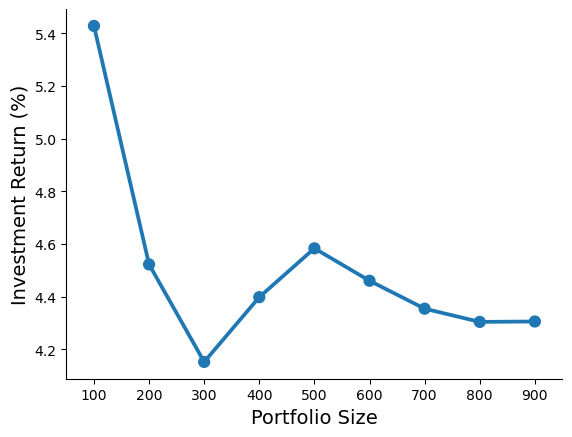

In [47]:
result_sensitivity = []

## Vary the portfolio size from 100 to 1000
random_forest = rf1213
for num_loans in list(range(100,1000,100)):
    reg_0 = test_investments(data_dict1213, regressor=reg_rf_separate1213, classifier=random_forest, 
                            strategy='Two-stage', num_loans=num_loans)
    result_sensitivity.append(reg_0['ret_PESS']['average return'])

result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(x=np.array(list(range(100, 1000, 100))), y=result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)', size=14)
plt.xlabel('Portfolio Size', size=14)
plt.show()


## Save the models in one file. or save the whole session in a dill file
Some of the models take long time to train. You may put your models in a dictionary and save it by running: 

In [48]:
# save all time-consuming models in one dict_ 
models_to_save = {}
models_to_save['rf1213'] = rf1213
models_to_save['reg_rf1213'] = reg_rf1213
models_to_save['reg_rf_separate1213'] = reg_rf_separate1213
models_to_save['reg_mlp1213'] = reg_mlp1213
models_to_save['l1_logistic1213'] = l1_logistic1213
# ... etc.

In [24]:
models_to_save['reg_rf_separate1213'] = reg_rf_separate1213

In [26]:
# os.path.abspath(os.getcwd()) # get current directory
filename = './week4_saved_models'
outfile = open(filename,'wb')
pickle.dump(models_to_save, outfile)
outfile.close()

In [50]:
# Save the whole session as a dill file
# !conda install dill -y
# import dill
# dill.dump_session('week4.pkl')

#The above command dumps a file in the current directory which you can load later as follows
# import dill
# dill.load_session('week4.pkl')